In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader
from vae.datasets_randomized import VolSurfaceDataSetRand, CustomBatchSampler
from vae.cvae_with_mem_randomized import CVAEMemRand
from vae.utils import *
from eval_scripts.eval_single_day import *
import os, sys
from typing import Dict

In [2]:
set_seeds(0)
torch.set_default_dtype(torch.float64)
num_epochs = 500
ctx_len = 4
start_day = 4950
days_to_generate = 100
num_vaes = 1000

In [3]:
data = np.load("data/vol_surface_with_ret.npz")
vol_surf_data = data["surface"]
ret_data = data["ret"]
level_data = data["levels"]
skew_data = data["skews"]
slope_data = data["slopes"]
ex_data = np.concatenate([ret_data[...,np.newaxis], skew_data[...,np.newaxis], slope_data[...,np.newaxis]], axis=-1)
print(ex_data.shape)
train_dataset = VolSurfaceDataSetRand(vol_surf_data[:4000])
valid_dataset = VolSurfaceDataSetRand(vol_surf_data[4000:5000])
test_dataset = VolSurfaceDataSetRand(vol_surf_data[5000:])
train_batch_sampler = CustomBatchSampler(train_dataset, 64)
valid_batch_sampler = CustomBatchSampler(valid_dataset, 16)
test_batch_sampler = CustomBatchSampler(test_dataset, 16)
train_simple = DataLoader(train_dataset, batch_sampler=train_batch_sampler)
valid_simple = DataLoader(valid_dataset, batch_sampler=valid_batch_sampler)
test_simple = DataLoader(test_dataset, batch_sampler=test_batch_sampler)

train_dataset2 = VolSurfaceDataSetRand((vol_surf_data[:4000], ex_data[:4000]))
valid_dataset2 = VolSurfaceDataSetRand((vol_surf_data[4000:5000], ex_data[4000:5000]))
test_dataset2 = VolSurfaceDataSetRand((vol_surf_data[5000:], ex_data[5000:]))
train_batch_sampler2 = CustomBatchSampler(train_dataset2, 64)
valid_batch_sampler2 = CustomBatchSampler(valid_dataset2, 16)
test_batch_sampler2 = CustomBatchSampler(test_dataset2, 16)
train_ex = DataLoader(train_dataset2, batch_sampler=train_batch_sampler2)
valid_ex = DataLoader(valid_dataset2, batch_sampler=valid_batch_sampler2)
test_ex = DataLoader(test_dataset2, batch_sampler=test_batch_sampler2)

(5822, 3)


# no ex feats

In [4]:
model_data = torch.load("test_spx/2023_08_27_simple/model_0.pt") # latent_dim=5, surface_hidden=[5,5,5], mem_hidden=100
model_config = model_data["model_config"]
model = CVAEMemRand(model_config)
model.load_weights(dict_to_load=model_data)
print(model)

CVAEMemRand(
  (encoder): CVAEMemRandEncoder(
    (surface_embedding): Sequential(
      (enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_0): ReLU()
      (enc_conv_1): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_1): ReLU()
      (enc_conv_2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_2): ReLU()
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (interaction): Identity()
    (mem): LSTM(125, 100, num_layers=2, batch_first=True, dropout=0.2)
    (z_mean_layer): Linear(in_features=100, out_features=5, bias=True)
    (z_log_var_layer): Linear(in_features=100, out_features=5, bias=True)
  )
  (ctx_encoder): CVAECtxMemRandEncoder(
    (ctx_surface_embedding): Sequential(
      (ctx_enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ctx_enc_activation_0): ReLU()
      (ctx_enc_conv_1): Conv2d(5, 5, kernel_size=(3, 3

Base z: tensor([[[-2.3104, -0.3733, -1.0608,  0.9995, -0.0200],
         [ 0.2103,  0.1772, -0.8305,  0.2387,  0.7335],
         [-1.3219,  1.3148, -0.6870,  1.4881, -0.4484],
         [-0.8910,  0.6749,  1.0469,  0.1543, -0.7499]]])


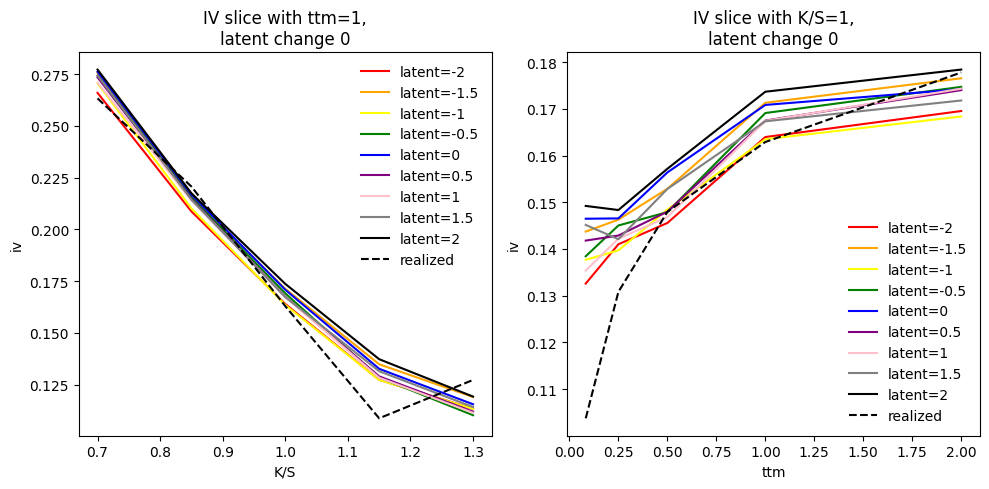

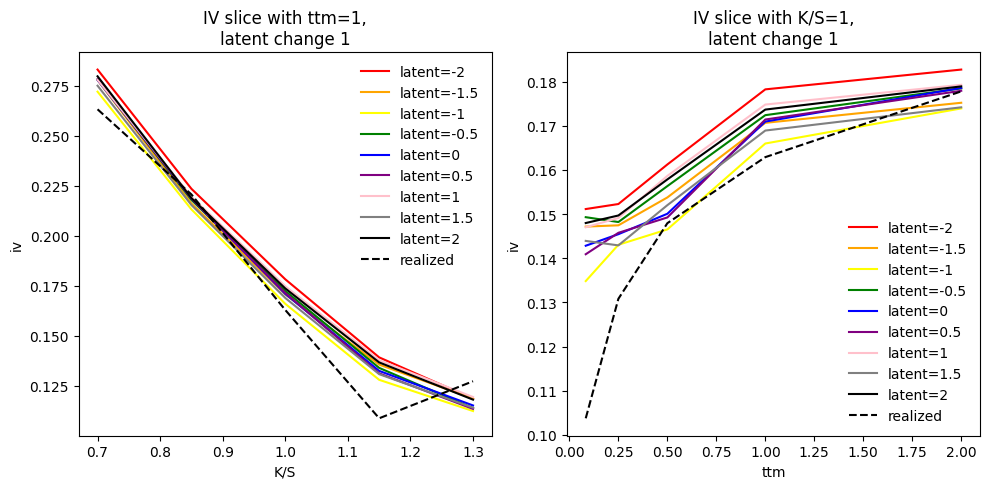

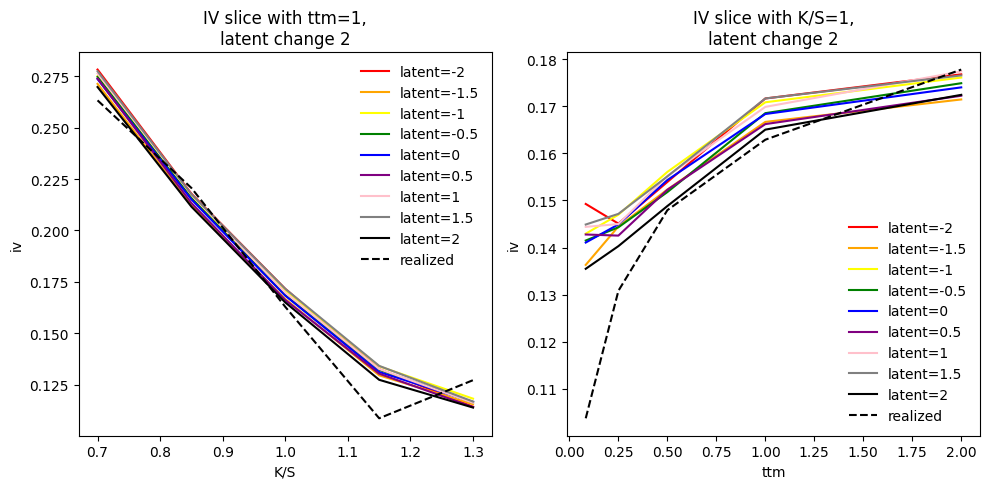

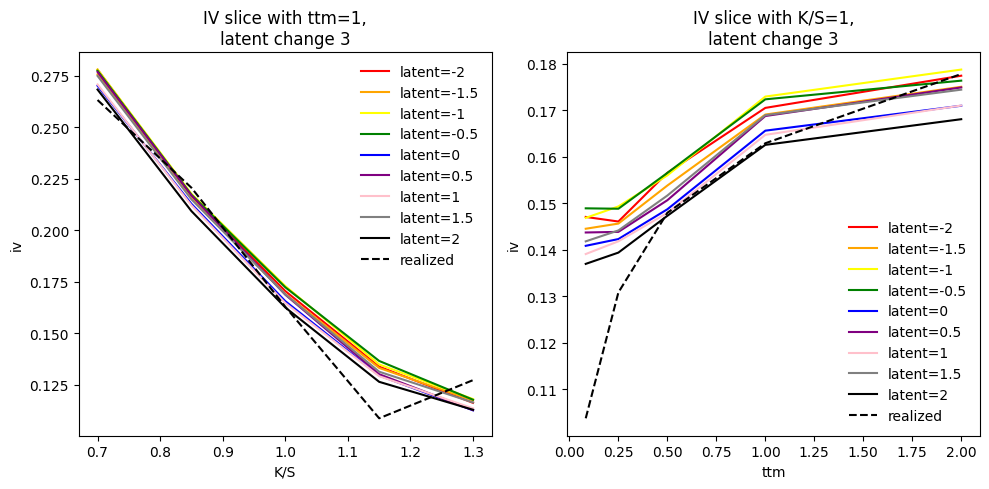

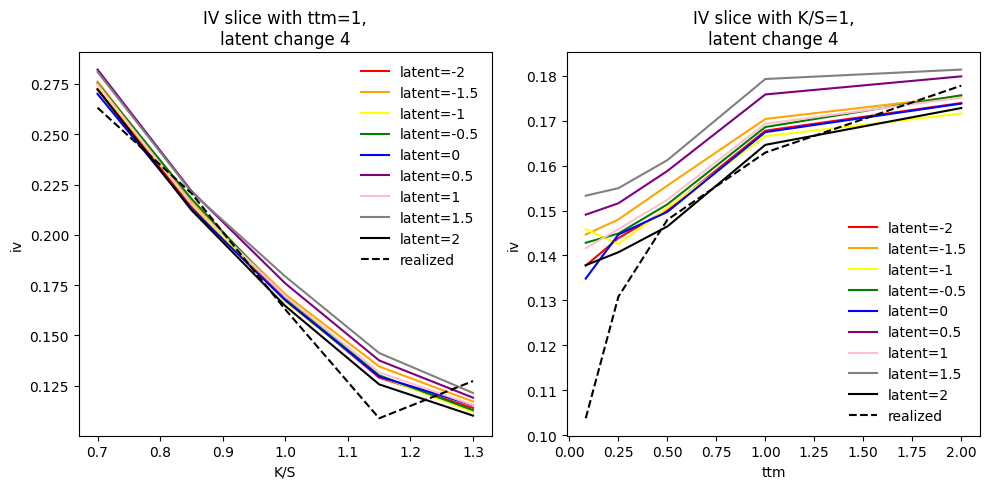

In [5]:
set_seeds(0)
base_z = torch.randn((1, 4, model.config["latent_dim"]))
z_value_range = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
outputs = []
for i in range(model.config["latent_dim"]):
    outputs.append(latent_manipulation_check(model, {"surface": torch.from_numpy(vol_surf_data[4998:5001])},
                                             base_z, i, z_value_range))
print(f"Base z: {base_z}")
for i in range(len(outputs)):
    plot_surface_slice_different_latents_single_latent(outputs[i], vol_surf_data[5001], i, z_value_range)
# plot_ret_different_latents(outputs, z_value_range)

# no loss on return

In [6]:
model_data = torch.load("test_spx/2023_08_27/model_0.pt") # latent_dim=5, surface_hidden=[5,5,5], mem_hidden=100
model_config = model_data["model_config"]
model = CVAEMemRand(model_config)
model.load_weights(dict_to_load=model_data)
print(model)

CVAEMemRand(
  (encoder): CVAEMemRandEncoder(
    (surface_embedding): Sequential(
      (enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_0): ReLU()
      (enc_conv_1): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_1): ReLU()
      (enc_conv_2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_2): ReLU()
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (ex_feats_embedding): Identity()
    (interaction): Identity()
    (mem): LSTM(128, 100, num_layers=2, batch_first=True, dropout=0.2)
    (z_mean_layer): Linear(in_features=100, out_features=5, bias=True)
    (z_log_var_layer): Linear(in_features=100, out_features=5, bias=True)
  )
  (ctx_encoder): CVAECtxMemRandEncoder(
    (ctx_surface_embedding): Sequential(
      (ctx_enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ctx_enc_activation_0): ReLU()
      (ctx_enc_co

Base z: tensor([[[-2.3104, -0.3733, -1.0608,  0.9995, -0.0200],
         [ 0.2103,  0.1772, -0.8305,  0.2387,  0.7335],
         [-1.3219,  1.3148, -0.6870,  1.4881, -0.4484],
         [-0.8910,  0.6749,  1.0469,  0.1543, -0.7499]]])


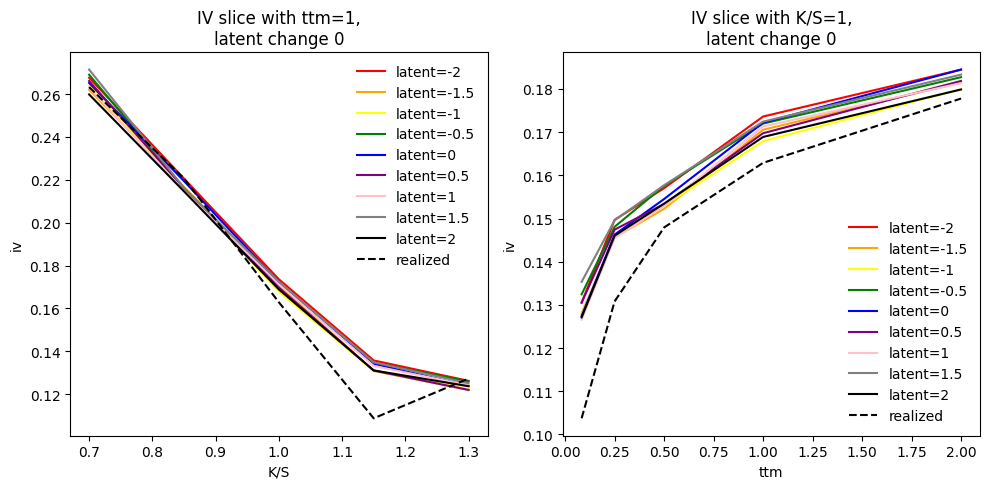

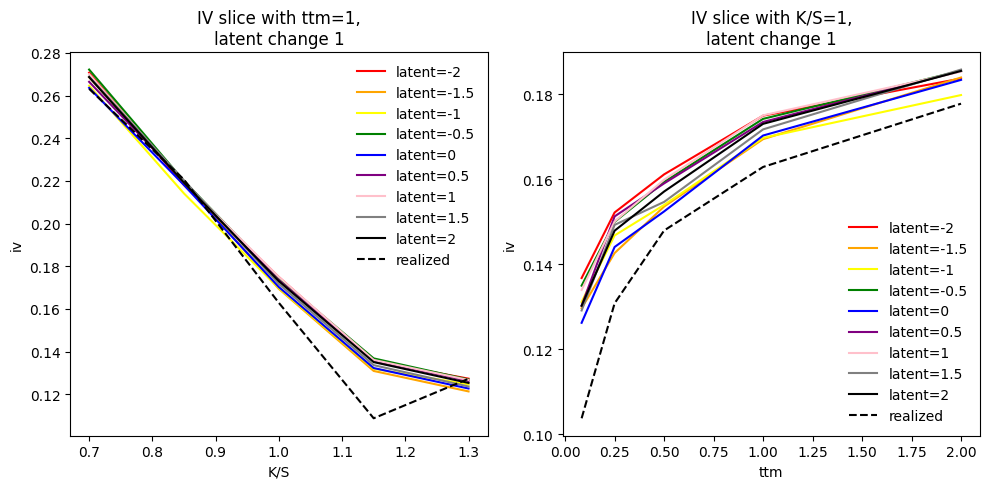

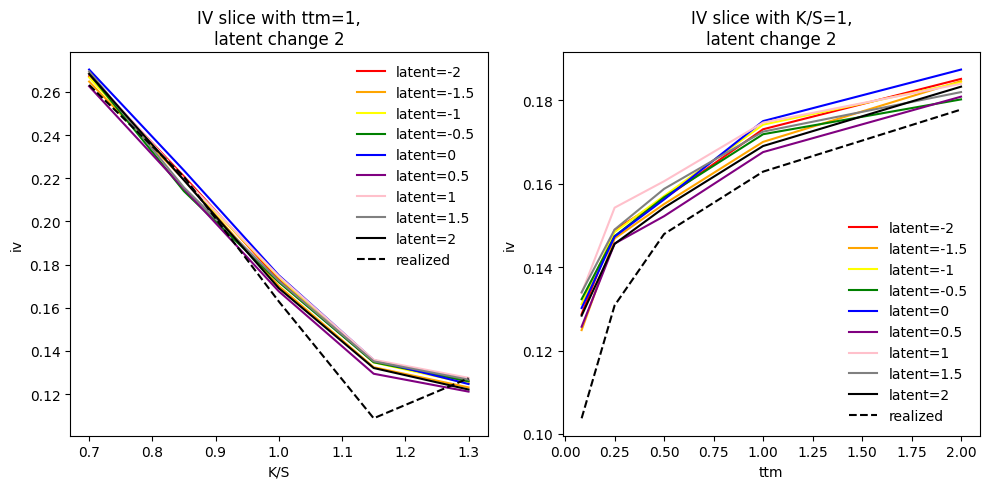

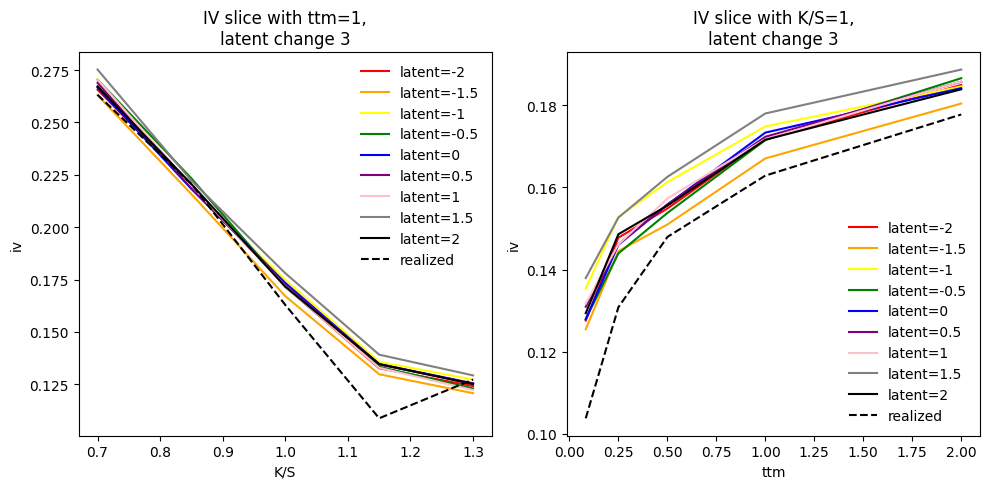

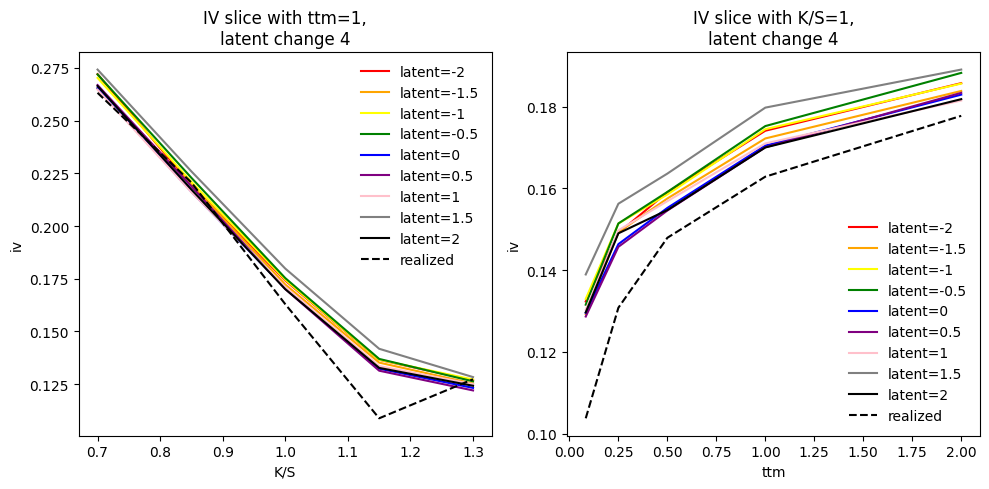

In [7]:
set_seeds(0)
base_z = torch.randn((1, 4, model.config["latent_dim"]))
z_value_range = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
outputs = []
for i in range(model.config["latent_dim"]):
    outputs.append(latent_manipulation_check(model, {"surface": torch.from_numpy(vol_surf_data[4998:5001]), 
                                                     "ex_feats": torch.from_numpy(ex_data[4998:5001])},
                                             base_z, i, z_value_range))
print(f"Base z: {base_z}")
for i in range(len(outputs)):
    plot_surface_slice_different_latents_single_latent(outputs[i], vol_surf_data[5001], i, z_value_range)
# plot_ret_different_latents(outputs, z_value_range)

# loss on return

In [8]:
model_data = torch.load("test_spx/2023_08_27/model_1.pt") # latent_dim=5, surface_hidden=[5,5,5], mem_hidden=100
model_config = model_data["model_config"]
model = CVAEMemRand(model_config)
model.load_weights(dict_to_load=model_data)
print(model)

CVAEMemRand(
  (encoder): CVAEMemRandEncoder(
    (surface_embedding): Sequential(
      (enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_0): ReLU()
      (enc_conv_1): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_1): ReLU()
      (enc_conv_2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_2): ReLU()
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (ex_feats_embedding): Identity()
    (interaction): Identity()
    (mem): LSTM(128, 100, num_layers=2, batch_first=True, dropout=0.2)
    (z_mean_layer): Linear(in_features=100, out_features=5, bias=True)
    (z_log_var_layer): Linear(in_features=100, out_features=5, bias=True)
  )
  (ctx_encoder): CVAECtxMemRandEncoder(
    (ctx_surface_embedding): Sequential(
      (ctx_enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ctx_enc_activation_0): ReLU()
      (ctx_enc_co

Base z: tensor([[[-2.3104, -0.3733, -1.0608,  0.9995, -0.0200],
         [ 0.2103,  0.1772, -0.8305,  0.2387,  0.7335],
         [-1.3219,  1.3148, -0.6870,  1.4881, -0.4484],
         [-0.8910,  0.6749,  1.0469,  0.1543, -0.7499]]])


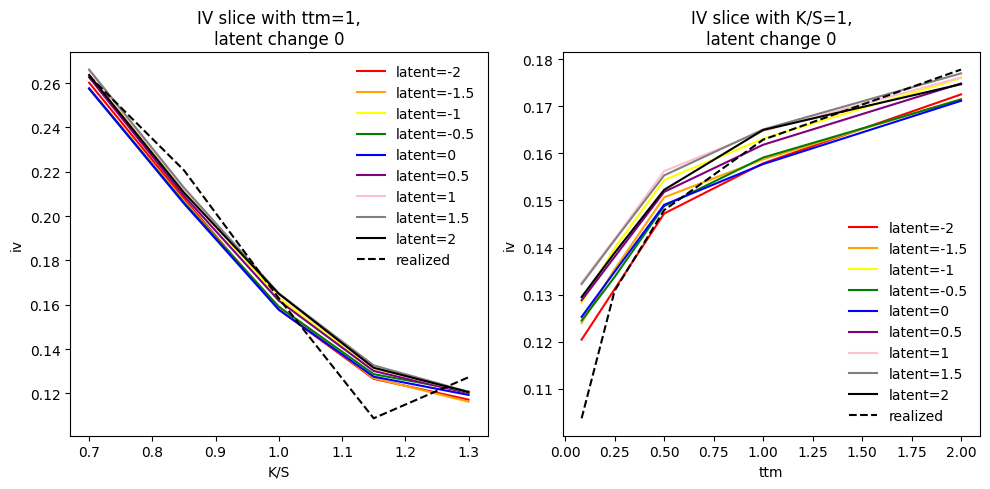

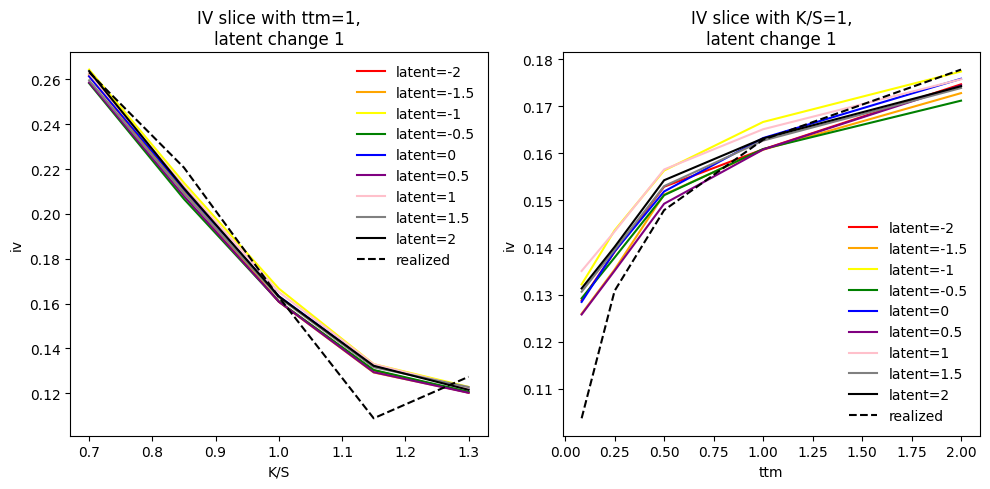

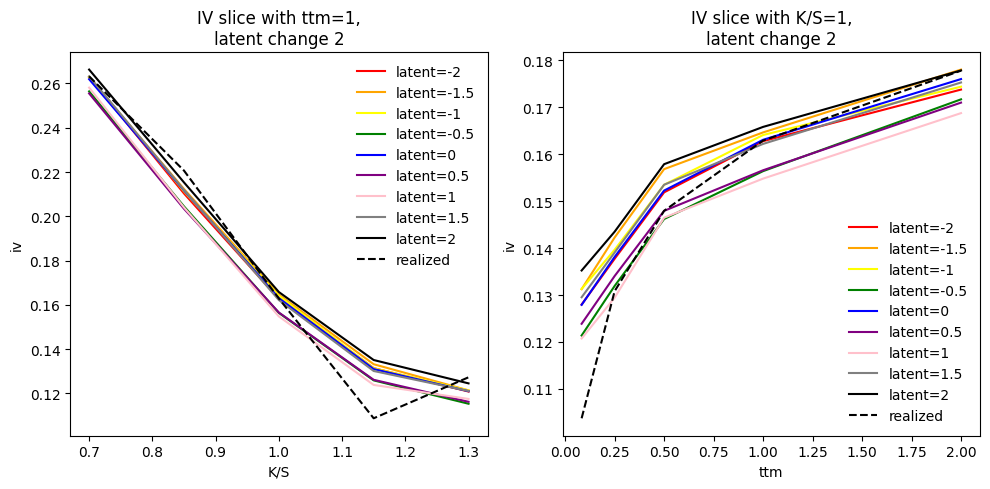

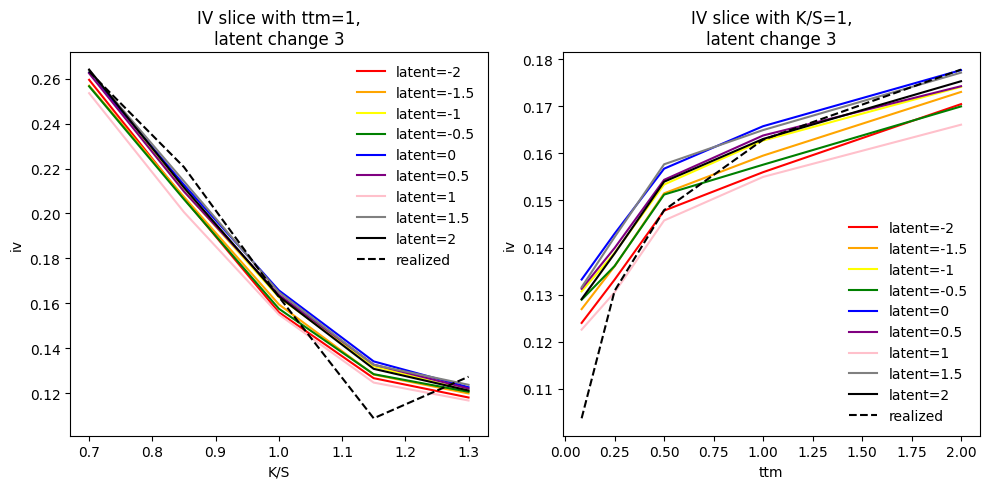

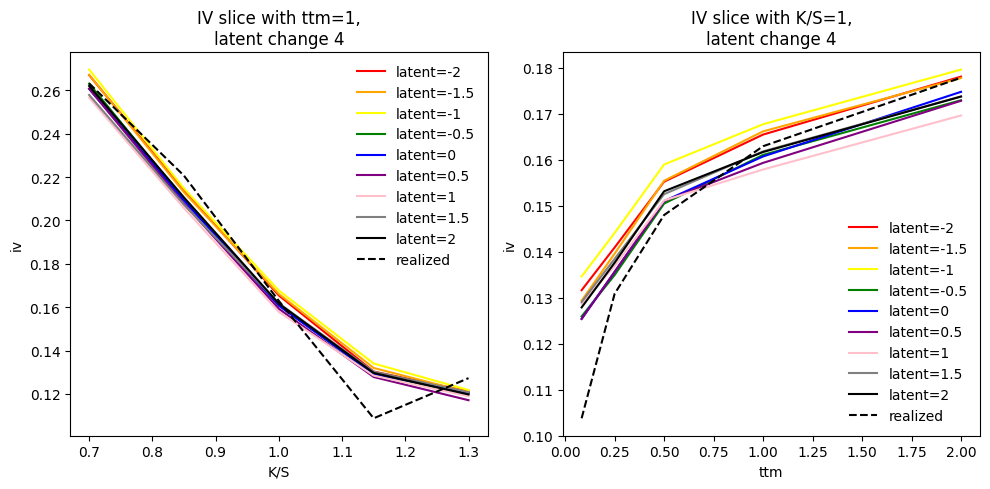

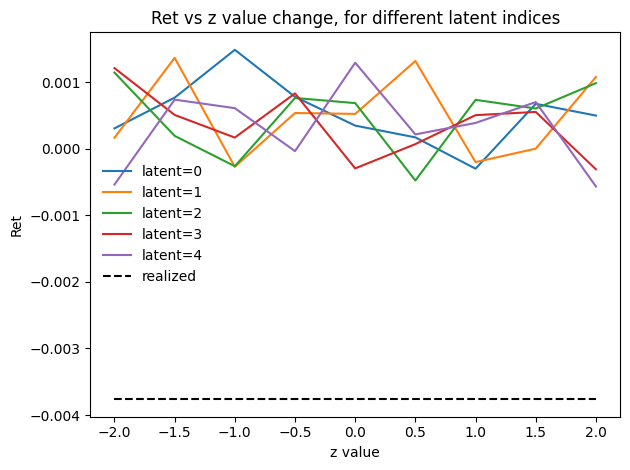

In [9]:
set_seeds(0)
base_z = torch.randn((1, 4, model.config["latent_dim"]))
z_value_range = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
outputs = []
for i in range(model.config["latent_dim"]):
    outputs.append(latent_manipulation_check(model, {"surface": torch.from_numpy(vol_surf_data[4998:5001]), 
                                                     "ex_feats": torch.from_numpy(ex_data[4998:5001])},
                                             base_z, i, z_value_range))
print(f"Base z: {base_z}")
for i in range(len(outputs)):
    plot_surface_slice_different_latents_single_latent(outputs[i], vol_surf_data[5001], i, z_value_range)
plot_ret_different_latents(outputs, ex_data[5001, 0], z_value_range)

Base z: tensor([[[-2.3104, -0.3733, -1.0608,  0.9995, -0.0200],
         [ 0.2103,  0.1772, -0.8305,  0.2387,  0.7335],
         [-1.3219,  1.3148, -0.6870,  1.4881, -0.4484],
         [-0.8910,  0.6749,  1.0469,  0.1543, -0.7499]]])


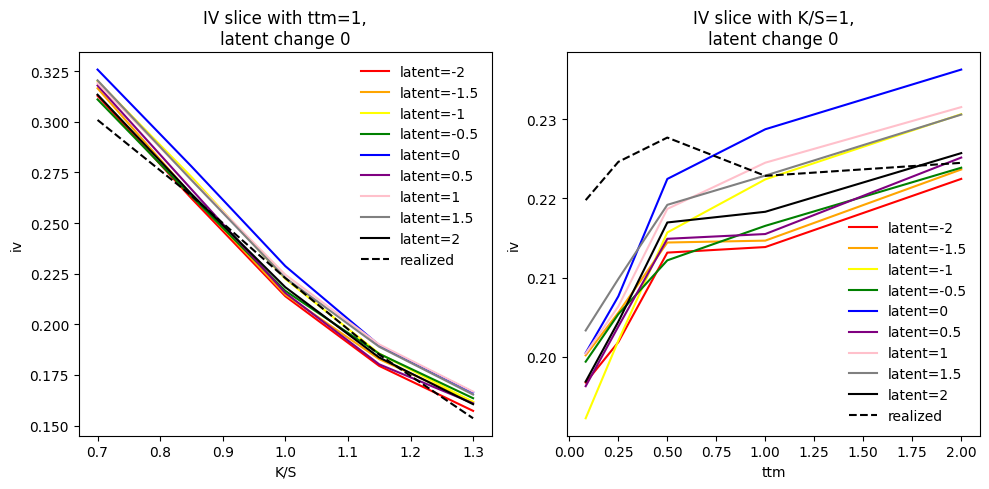

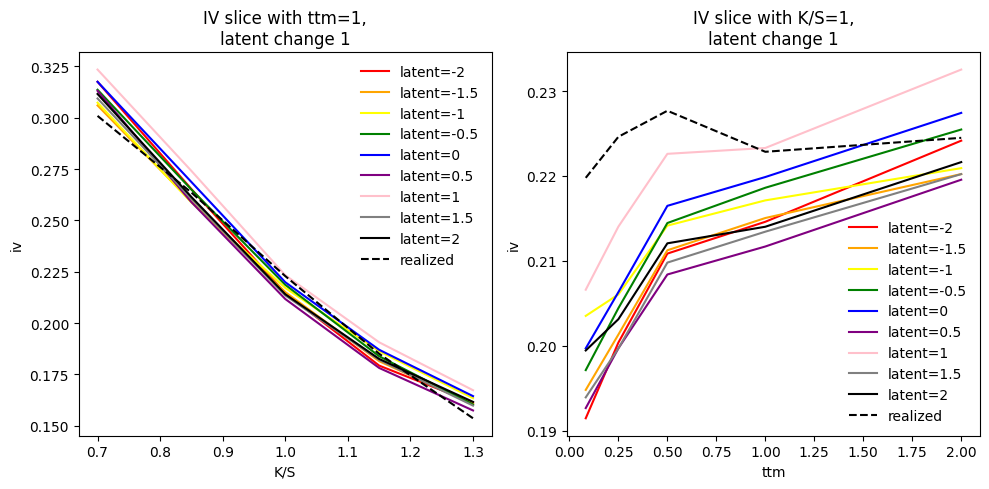

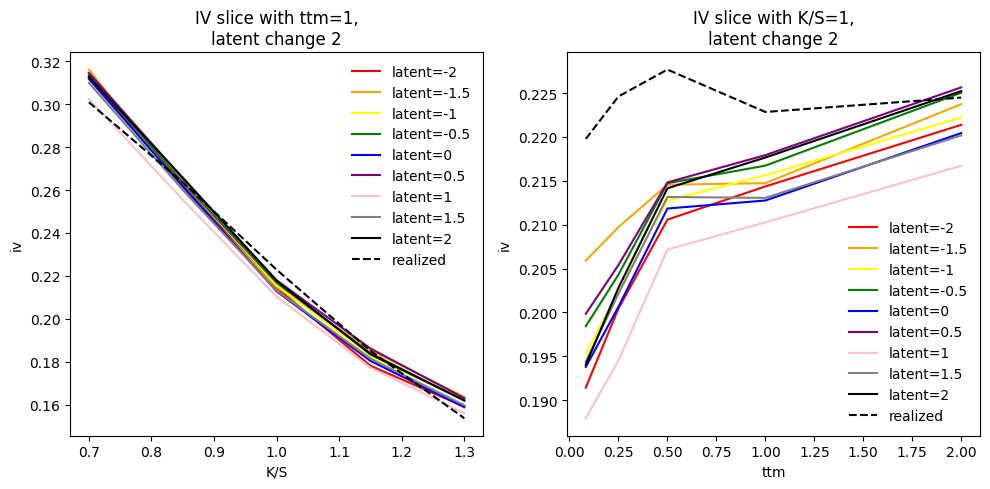

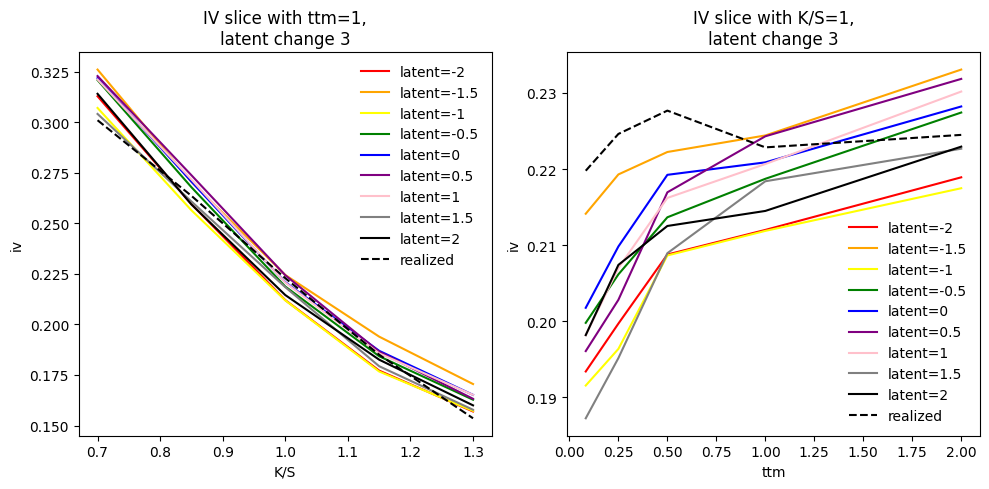

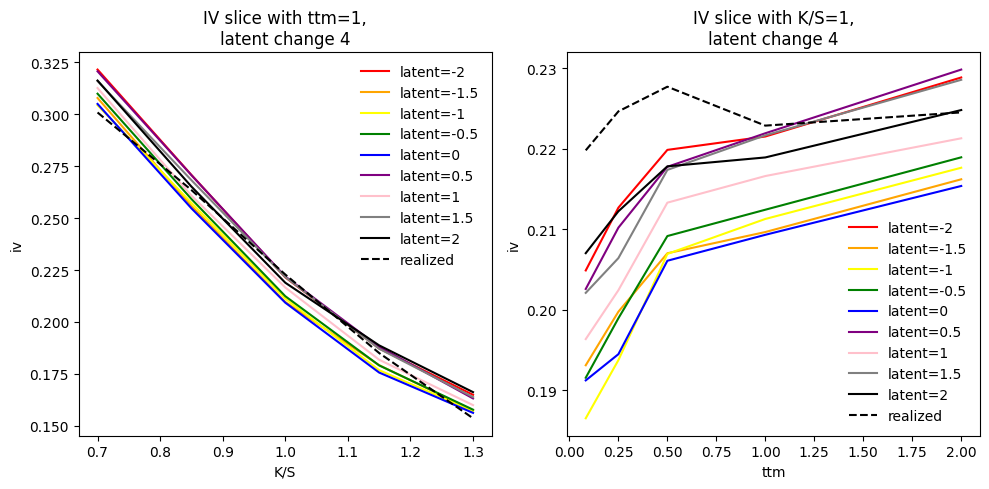

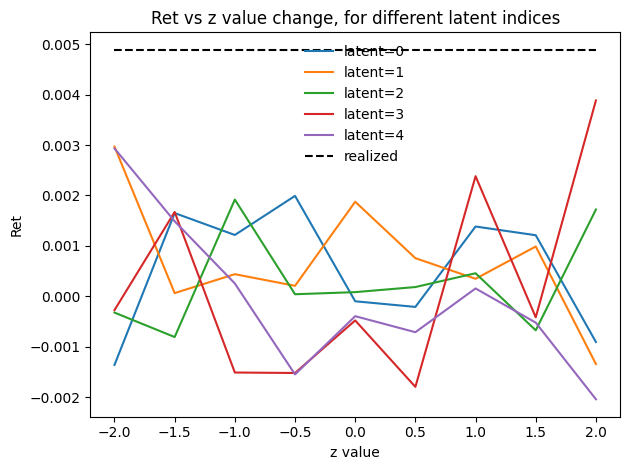

In [10]:
set_seeds(0)
base_z = torch.randn((1, 4, model.config["latent_dim"]))
z_value_range = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
outputs = []
for i in range(model.config["latent_dim"]):
    outputs.append(latent_manipulation_check(model, {"surface": torch.from_numpy(vol_surf_data[1998:2001]), 
                                                     "ex_feats": torch.from_numpy(ex_data[1998:2001])},
                                             base_z, i, z_value_range))
print(f"Base z: {base_z}")
for i in range(len(outputs)):
    plot_surface_slice_different_latents_single_latent(outputs[i], vol_surf_data[2001], i, z_value_range)
plot_ret_different_latents(outputs, ex_data[2001, 0], z_value_range)